In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_DIR = "../data"
TICKERS = ["SPY", "QQQ", "IWM"]
FEATURE_PREFIX = "features_"
FEATURE_COLUMNS = [
    "ret_1",
    "daily_return",
    "stoch_d",
    "rolling_vol_5",
    "bb_width",
    "momentum_10",
    "rsi_14",
    "stoch_k",
    "atr_14",
    "macd_signal",
    "macd"
]



TARGET_COLUMN = "target"

In [4]:
frames= []

for ticker in TICKERS:
    path = os.path.join(DATA_DIR, f"{FEATURE_PREFIX}{ticker}.parquet")
    df = pd.read_parquet(path)
    df["ticker"] = ticker
    frames.append(df)

# Detect the date-like column first
date_col = next((col for col in frames[0].columns if col.lower().startswith("date")), None)
if date_col is None:
    raise KeyError(f"Could not find date column in {frames[0].columns.tolist()}")

data = pd.concat(frames).sort_values(date_col).reset_index(drop=True)

print(f"✅ Combined dataset shape: {data.shape}")


✅ Combined dataset shape: (7788, 32)


In [5]:
X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMN]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False  # no shuffle for time series
)
print(f"📊 Train size: {len(X_train)} | Test size: {len(X_test)}")

📊 Train size: 5451 | Test size: 2337


In [7]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
print("✅ Model trained.")

✅ Model trained.


In [8]:
# Predict probabilities
probs = model.predict_proba(X_test)[:, 1]

# Filter: only predict if confidence is high
threshold = 0.55
confident_preds = (probs > threshold).astype(int)

print(f"🔍 Predictions made with confidence > {threshold}: {(probs > threshold).sum()} of {len(probs)}")

from sklearn.metrics import classification_report
print(classification_report(y_test, confident_preds, target_names=["Down", "Up"]))


🔍 Predictions made with confidence > 0.55: 1082 of 2337
              precision    recall  f1-score   support

        Down       0.45      0.52      0.49      1087
          Up       0.52      0.45      0.48      1250

    accuracy                           0.48      2337
   macro avg       0.49      0.49      0.48      2337
weighted avg       0.49      0.48      0.48      2337



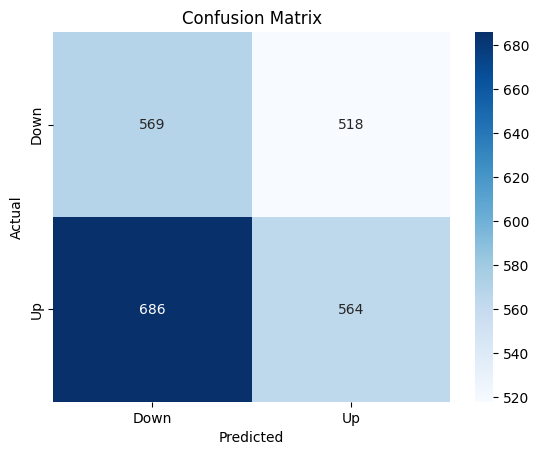

In [9]:
cm = confusion_matrix(y_test, confident_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
joblib.dump(model, os.path.join(DATA_DIR, "rf_model.pkl"))
print("💾 Model saved to data/rf_model.pkl")

💾 Model saved to data/rf_model.pkl


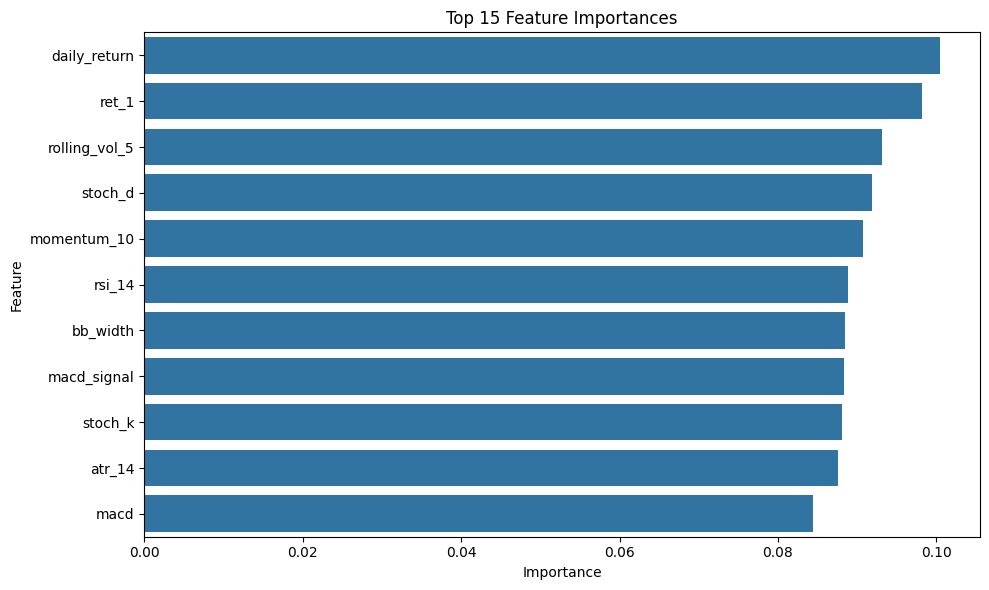

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame of feature importances
importances = model.feature_importances_
feat_df = pd.DataFrame({
    "feature": FEATURE_COLUMNS,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_df.head(15))
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [22]:
import joblib

# Save model to file
joblib.dump(model, "../models/random_forest_model.joblib")


['../models/random_forest_model.joblib']